## 房價預測(回歸)

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd  
import seaborn as sns 
from sklearn.datasets import load_boston
import warnings
warnings.filterwarnings('ignore')

載入scikit-learn的boston housing [dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html)

In [2]:
# load boston_dataset
boston_dataset = load_boston()

載入後可以看到這個資料集像json格式，可以接著用一下程式碼看資料集的keys:
- data： 每個房子的資訊
- target： 每個房子的價格
- feature_names： 每個房子的特徵
- DESCR： 這個資料集的描述

In [3]:
# 取得每個特徵描述
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

將資料轉換成pd.DataFrame格式。目標輸出是MEDIV，剩下的就是特徵即為輸入特徵。

In [4]:
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston['MEDV'] = boston_dataset.target
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## 資料前處理
進一步處理之前先確認是否有缺失值：

In [5]:
boston.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

## 資料探索
接下來用簡單的資料視覺來看一下細部資料之間的關係。
MEDIV房價變數的分佈大致呈鐘型常態分佈：

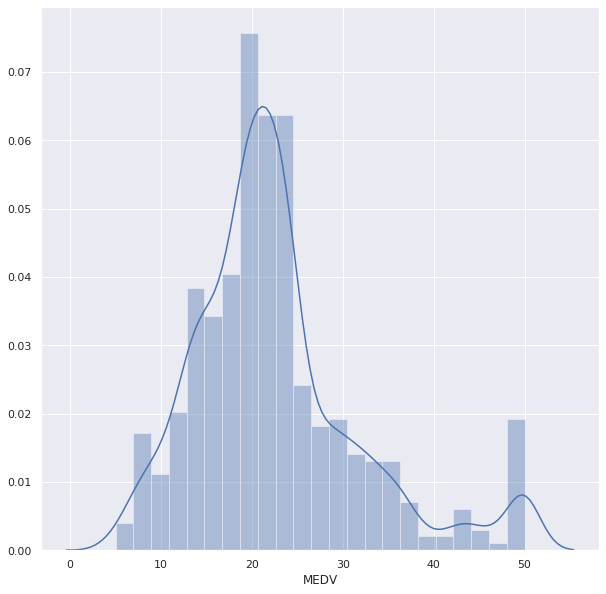

In [6]:
# 用seaborn一次把圖表的美化格式設定好，這裡是只有先設定圖表長寬
sns.set(rc={'figure.figsize':(10,10)})
# 使用的資料是房價MEDIV
sns.distplot(boston['MEDV'])
plt.show()

接下來我們可以看每個變數之間的關係，透過相關係數去觀察有哪些特徵變數和目標變數有較高的相關性等：

1. 跟MEDV（房價）高度相關的是LSTAT（中低收入戶佔當地居住人口的比例）和RM（房子有幾間房間）這兩個變數。
2. 此外也看到DIS（到波士頓商業中心的距離）和AGE（屋齡），INDUS（非零售業土地使用比例）和ZN（居住使用土地比例）這兩組變數有多元共線性問題，所以未來如果要做其他模型，避免同時使用這兩組中的變數。

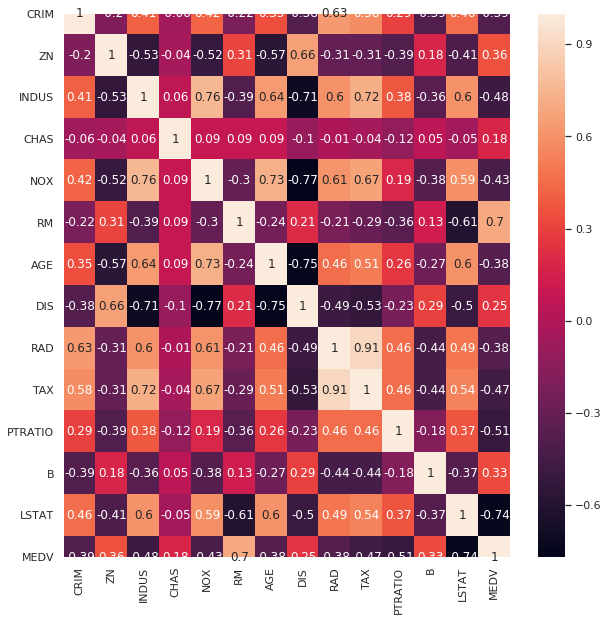

In [7]:
correlation_matrix = boston.corr().round(2)
# annot = True 讓我們可以把數字標進每個格子裡
sns.heatmap(data=correlation_matrix, annot = True)

可以用LSTAT和RM來做出預測MEDV的模型。再次把這兩個變數跟房價變數的關係畫出來，可以看到兩者和房價變數都接近線性關係：

- LSTAT和MEDV是負向關係
- RM和MEDV正向關係

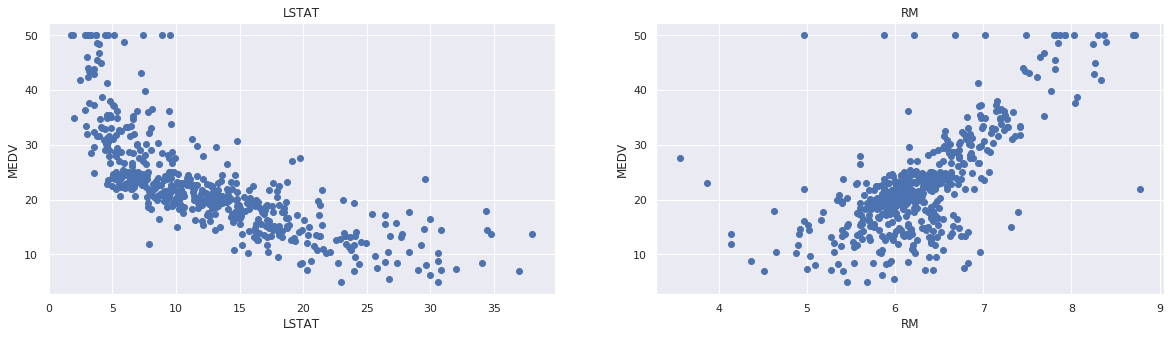

In [8]:
# 設定整張圖的長寬
plt.figure(figsize=(20, 5))
features = ['LSTAT', 'RM']
target = boston['MEDV']
for i, col in enumerate(features):
    # 排版1 row, 2 columns, nth plot：在jupyter notebook上兩張並排 
    plt.subplot(1, len(features) , i+1)
    # add data column into plot
    x = boston[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('MEDV')

## 切割訓練資料

In [9]:
from sklearn.model_selection import train_test_split
X  = boston.drop(['MEDV'],axis=1).values
y = boston['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print('Training data shape:',X_train.shape)
print('Testing data shape:',X_test.shape)

Training data shape: (455, 13)
Testing data shape: (51, 13)


## CatBoost(回歸器)

Parameters:
- iterations: 總共迭代的次數，即決策樹的個數。預設值為1000。
- use_best_model: 設定 True 時必須給定驗證集，將會留下驗證集分中數最高的模型。
- early_stopping_rounds: 連續訓練N代，若結果未改善則提早停止訓練。
- od_type: IncToDec/Iter，預設 Iter 防止 Overfitting 評估方式，若設定前者需要設定閥值。
- eval_metric: 模型評估方式。
- loss_function: 計算loss方法。
- verbose: True(1)/Flase(0)，預設1顯示訓練過程。
- random_state: 亂數種子，確保每次訓練結果都一樣。
- learning_rate: 預設 automatically。
- depth: 樹的深度，預設6。
- cat_features: 輸入類別特徵的索引，它會自動幫你處理。
- one_hot_max_size=2: 对于某些变量进行one-hot编码

[參考](https://catboost.ai/docs/concepts/python-reference_parameters-list.html)

Attributes:
- feature_importances_: 查詢模型特徵的重要程度。

Methods:
- fit: 放入X、y進行模型擬合。
- predict: 預測並回傳預測類別。
- score: 預測成功的比例。

In [10]:
from catboost import CatBoostRegressor

# 建立模型
model = CatBoostRegressor(random_state=42,
                         loss_function='RMSE',
                         eval_metric='RMSE',
                         use_best_model=True)
# 使用訓練資料訓練模型
model.fit(X_train,y_train, eval_set=(X_test, y_test), verbose=0, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.039706
0:	learn: 9.0707774	test: 7.8518455	best: 7.8518455 (0)	total: 47.4ms	remaining: 47.3s
10:	learn: 7.1990576	test: 6.2643351	best: 6.2643351 (10)	total: 58.8ms	remaining: 5.28s
20:	learn: 5.8856371	test: 5.1527100	best: 5.1527100 (20)	total: 66.2ms	remaining: 3.09s
30:	learn: 4.9439762	test: 4.4003630	best: 4.4003630 (30)	total: 73.8ms	remaining: 2.31s
40:	learn: 4.2818510	test: 3.8445807	best: 3.8445807 (40)	total: 81.2ms	remaining: 1.9s
50:	learn: 3.7680113	test: 3.4567434	best: 3.4567434 (50)	total: 88.7ms	remaining: 1.65s
60:	learn: 3.4108544	test: 3.2079344	best: 3.2079344 (60)	total: 96ms	remaining: 1.48s
70:	learn: 3.1538940	test: 3.0288177	best: 3.0207581 (69)	total: 103ms	remaining: 1.35s
80:	learn: 2.9547173	test: 2.9370996	best: 2.9370996 (80)	total: 111ms	remaining: 1.26s
90:	learn: 2.7919666	test: 2.8426196	best: 2.8426196 (90)	total: 118ms	remaining: 1.18s
100:	learn: 2.6719827	test: 2.7780149	best: 2.7780149 (100)	total: 125ms	remaining: 1.12

In [12]:
print("Score: ", model.score(X_test, y_test))

Score:  0.9149112257214276


## Feature Importance

Text(0.5, 0, 'CatBoost Feature Importance')

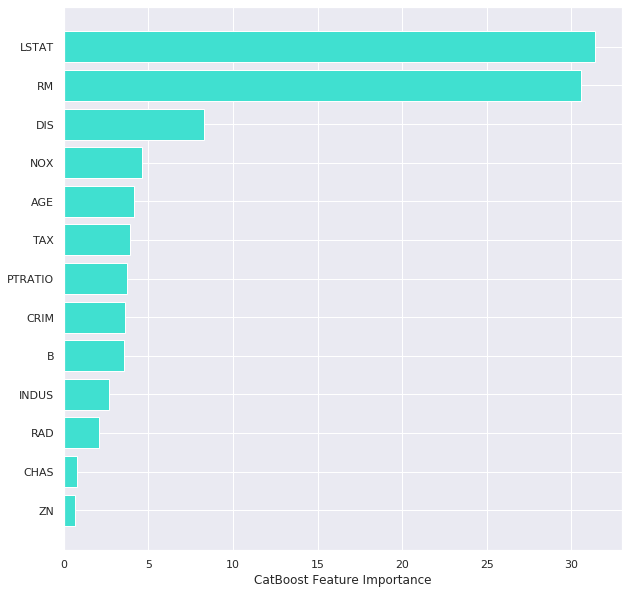

In [13]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(boston_dataset.feature_names[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

## SHAP 解釋模型
[更多參考](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Catboost%20tutorial.html)

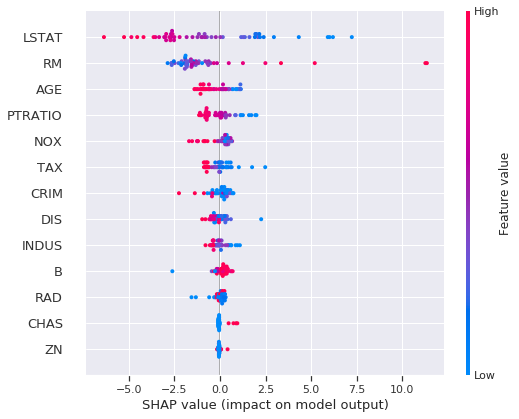

In [21]:
from catboost import Pool
import shap
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
# summarize the effects of all the features
shap.summary_plot(shap_values, X_test, feature_names=boston_dataset.feature_names)

## 特徵篩選
訓練過程中會自動從資料中篩選對模型預測有用的特徵，並移除無幫助預測的特徵。

- [參考](https://catboost.ai/docs/concepts/python-reference_catboost_select_features.html)

In [46]:
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm

# feature_names = ['F{}'.format(i) for i in range(X_train.shape[1])]
train_pool = Pool(X_train, y_train, feature_names=boston_dataset.feature_names.tolist())
test_pool = Pool(X_test, y_test, feature_names=boston_dataset.feature_names.tolist())

model = CatBoostRegressor(random_state=42,
                         loss_function='RMSE',
                         eval_metric='RMSE',
                         use_best_model=True)
summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select='0-12',
    num_features_to_select=3,
    steps=2,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=False
)
summary

{'selected_features': [5, 10, 12],
 'eliminated_features_names': ['DIS',
  'B',
  'ZN',
  'CHAS',
  'RAD',
  'INDUS',
  'CRIM',
  'AGE',
  'TAX',
  'NOX'],
 'eliminated_features': [7, 11, 1, 3, 8, 2, 0, 6, 9, 4],
 'selected_features_names': ['RM', 'PTRATIO', 'LSTAT']}

## Grid search
對模型的指定參數值進行簡單的網格搜索。

- [參考](https://catboost.ai/docs/concepts/python-reference_catboostregressor_grid_search.html)

In [ ]:
from catboost import CatBoostRegressor
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

model = CatBoostRegressor(random_state=42,
                         loss_function='RMSE',
                         eval_metric='RMSE')
model.grid_search(grid, X_train,y_train)

### 模型評估
scikit-learn 決策樹迴歸模型的score函式是R2 score，可作為模型評估依據，其數值越接近於1代表模型越佳。
除了R2 score還有其他許多回歸模型的評估方法，例如： MSE、MAE、RMSE。

In [49]:
from sklearn import metrics
# 使用訓練資料預測
y_pred=model.predict(X_train)
print("訓練集")
print('R2 score: ', model.score(X_train,y_train))
mse = metrics.mean_squared_error(y_train, y_pred)
print('MSE score: ', mse)

# 使用測試資料預測
y_pred=model.predict(X_test)
print("測試集")
print('R2 score: ', model.score(X_test,y_test))
mse = metrics.mean_squared_error(y_test, y_pred)
print('MSE score: ', mse)

訓練集
R2 score:  0.9924876574787395
MSE score:  0.650752399002141
測試集
R2 score:  0.9149112257214276
MSE score:  5.312451049358462


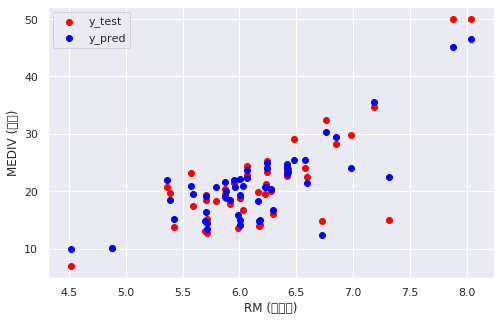

In [20]:
# plotting the y_test vs y_pred
plt.figure(figsize=(8,5))
plt.scatter(X_test[:,5], y_test, color='red', label='y_test')
plt.scatter(X_test[:,5], y_pred, color='blue', label='y_pred')
plt.xlabel('RM (房間數)')
plt.ylabel('MEDIV (房價)')
plt.legend(loc='upper left')
plt.show()

In [15]:
import numpy as np
from sklearn.model_selection import RepeatedKFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4],[5,6],[7,8]])
y = np.array([0, 0, 1, 1,0,0])
rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=2652124)
for train_index, test_index in rkf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


TRAIN: [0 4 5] TEST: [1 2 3]
TRAIN: [1 2 3] TEST: [0 4 5]
TRAIN: [1 3 5] TEST: [0 2 4]
TRAIN: [0 2 4] TEST: [1 3 5]
